<a href="https://colab.research.google.com/github/braxtonowens/OneraDataset/blob/master/Onera_Multispec_FC_Siam_conc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/braxtonowens/OneraDataset.git

Cloning into 'OneraDataset'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1953 (delta 1), reused 3 (delta 1), pack-reused 1945
Receiving objects: 100% (1953/1953), 910.13 MiB | 39.71 MiB/s, done.
Resolving deltas: 100% (202/202), done.
Checking out files: 100% (1632/1632), done.


Here we take the original images and create lots of random smaller images returning arrays of the images and masks.

In [2]:
from osgeo import gdal
import numpy as np
import os
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt


# Choose from bands (B01, B02, B02, B04, B05, B06, B07, B08, B09, B10, B11, B12, B8A)
channels = ['B02','B03','B04','B08']
# path to Onera Dataset
mainDir = 'OneraDataset/OneraData'
images = '/images'
labels = '/labels'
IMAGE_SIZE = 96


def create_stacked_chips(channels, mainDir, images, labels, IMAGE_SIZE):
  #countImage = []
  mainPath = mainDir
  imgPath = mainDir + images
  lblPath = mainDir + labels
  img_list1 = np.zeros((908,96,96,4))
  img_list2 = np.zeros((908,96,96,4))
  lbl_list = np.zeros((908,96,96,1))
  city_ls = os.listdir(lblPath)
  city_ls.remove('README.txt')
  if not('mini_images' in os.listdir(mainPath)):
    os.mkdir(mainPath +'/mini_images')
    os.mkdir(mainPath +'/mini_labels')
  k = 0
  count = 0
  for city in city_ls:
    beforeList = []
    afterList = []
    lblList = []
    for channel in channels:
      img_file1 = imgPath + '/'+ city + '/imgs_1_rect/' + channel + '.tif'
      ds = gdal.Open(img_file1, gdal.GA_ReadOnly)
      rb = ds.GetRasterBand(1)
      beforeList.append(rb.ReadAsArray())
      img_file2 = imgPath + '/' + city + '/imgs_2_rect/' + channel + '.tif'
      ds = gdal.Open(img_file2, gdal.GA_ReadOnly)
      rb = ds.GetRasterBand(1)
      afterList.append(rb.ReadAsArray())
      lbl_file = lblPath + '/' + city + '/cm/' + city + '-cm' '.tif'
      ds = gdal.Open(lbl_file, gdal.GA_ReadOnly)
      rb = ds.GetRasterBand(1)
      lblList.append(rb.ReadAsArray())
    y = 0
    
    for i in range(beforeList[0].shape[1]//IMAGE_SIZE):
        x = 0
        for j in range(beforeList[0].shape[0]//IMAGE_SIZE):
            before_mini_img1 = beforeList[0][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            before_mini_img2 = beforeList[1][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            before_mini_img3 = beforeList[2][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            before_mini_img4 = beforeList[3][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]

            after_mini_img1 = afterList[0][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            after_mini_img2 = afterList[1][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            after_mini_img3 = afterList[2][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]
            after_mini_img4 = afterList[3][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE]


            lbl_mini_img1 = lblList[0][x:x+IMAGE_SIZE,y:y+IMAGE_SIZE] - 1

            count +=1 
            img_list1[k] = tf.stack([before_mini_img1,before_mini_img2,before_mini_img3,before_mini_img4],axis=2)
            img_list2[k] = tf.stack([after_mini_img1,after_mini_img2,after_mini_img3,after_mini_img4],axis=2)

            mini_lbl = np.expand_dims(lbl_mini_img1,2)
            lbl_list[k] = (mini_lbl)
            x += IMAGE_SIZE
            k +=1
        y += IMAGE_SIZE
  return img_list1/4095,img_list2/4095, lbl_list 

Uses sklearn library to split our data into training and testing batches.

In [3]:
from sklearn.model_selection import train_test_split
X1,X2,y = create_stacked_chips(channels, mainDir, images, labels, IMAGE_SIZE)

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size = .33, random_state = 48)


del X1,X2, y

Rotates all of the images 3 times to triple the data and then shuffles it all 

In [4]:
from random import randint
def randomRotation(X1_train, X2_train, y_train):
  aug_X1_train = np.zeros((len(X1_train) * 4,96,96,4))
  aug_X2_train = np.zeros((len(X2_train) * 4,96,96,4))
  aug_y_train = np.zeros((len(y_train) * 4,96,96,1))
  j = 0
  # Augment data
  for i in range(len(X1_train)):
    aug_X1_train[j] = X1_train[i]
    aug_X2_train[j] = X2_train[i]
    aug_y_train[j] = y_train[i]
    j+=1
    a = np.rot90(X1_train[i],1)
    c = np.rot90(X2_train[i],1)
    b = np.rot90(y_train[i],1)
    aug_X1_train[j] = a
    aug_X2_train[j] = c
    aug_y_train[j] = b
    j+=1
    a = np.rot90(X1_train[i],2)
    c = np.rot90(X2_train[i],2)
    b = np.rot90(y_train[i],2)
    aug_X1_train[j] = a
    aug_X2_train[j] = c
    aug_y_train[j] = b
    j+=1
    a = np.rot90(X1_train[i],3)
    c = np.rot90(X2_train[i],3)
    b = np.rot90(y_train[i],3)
    aug_X1_train[j] = a
    aug_X2_train[j] = c
    aug_y_train[j] = b
    j+=1

  # Shuffle data
  seed = np.random.randint(0, 100000)  
  np.random.seed(seed)  
  np.random.shuffle(aug_X1_train)  
  np.random.shuffle(aug_X2_train) 
  np.random.seed(seed)  
  np.random.shuffle(aug_y_train)     
  return aug_X1_train, aug_X2_train, aug_y_train
    

X1_train,X2_train,y_train = randomRotation(X1_train,X2_train,y_train)

Here is our model almost entirely inspired by https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ and https://github.com/zhixuhao/unet

In [5]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K



def unet(pretrained_weights = None,input_size = (96,96,4)):
    input1 = Input(input_size)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

    input2 = Input(input_size) 
    conv1_2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input2)
    conv1_2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_2)
    pool1_2 = MaxPooling2D(pool_size=(2, 2))(conv1_2)
    conv2_2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1_2)
    conv2_2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_2)
    pool2_2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)
    conv3_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2_2)
    conv3_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_2)
    conv3_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_2)
    pool3_2 = MaxPooling2D(pool_size=(2, 2))(conv3_2)
    conv4_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3_2)
    conv4_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    drop4_2 = Dropout(0.5)(conv4_2)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(drop4_2)


    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4_2))
    merge6 = concatenate([up6,conv4,drop4_2], axis = 3)

    
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
 
    merge7 = concatenate([up7,conv3,conv3_2], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  
    merge8 = concatenate([up8,conv2,conv2_2], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
   
    merge9 = concatenate([up9,conv1,conv1_2], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = [input1,input2], outputs = conv10) 

    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy' , metrics = ['accuracy']) # was 'binary_crossentropy'
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

Epoch 1/10
973/973 [==============================] - 12s 12ms/step - loss: 0.1531 - accuracy: 0.9676 - val_loss: 0.1343 - val_accuracy: 0.9686
Epoch 2/10
973/973 [==============================] - 10s 11ms/step - loss: 0.1397 - accuracy: 0.9676 - val_loss: 0.1371 - val_accuracy: 0.9686
Epoch 3/10
973/973 [==============================] - 10s 10ms/step - loss: 0.1372 - accuracy: 0.9676 - val_loss: 0.1312 - val_accuracy: 0.9686
Epoch 4/10
973/973 [==============================] - 10s 10ms/step - loss: 0.1348 - accuracy: 0.9676 - val_loss: 0.1288 - val_accuracy: 0.9686
Epoch 5/10
973/973 [==============================] - 10s 11ms/step - loss: 0.1341 - accuracy: 0.9676 - val_loss: 0.1347 - val_accuracy: 0.9686
Epoch 6/10
973/973 [==============================] - 10s 11ms/step - loss: 0.1319 - accuracy: 0.9676 - val_loss: 0.1292 - val_accuracy: 0.9686
Epoch 7/10
973/973 [==============================] - 10s 10ms/step - loss: 0.1301 - accuracy: 0.9676 - val_loss: 0.1245 - val_accuracy:

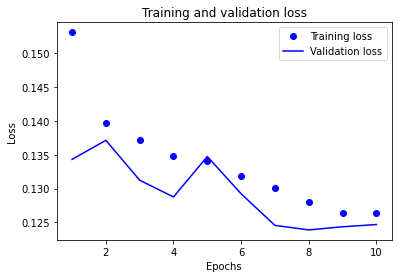

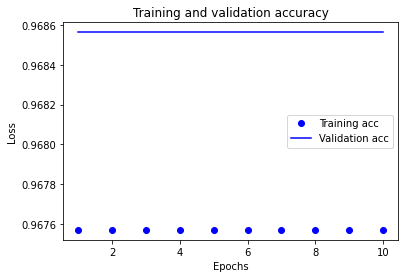

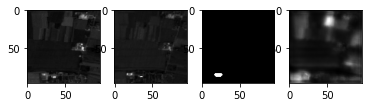

Dice similarity score is 0.026870635640312415


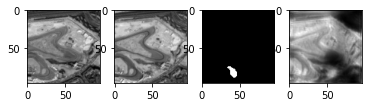

Dice similarity score is 0.01441056603212792


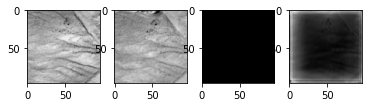

Dice similarity score is 0.0


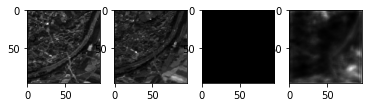

Dice similarity score is 0.0


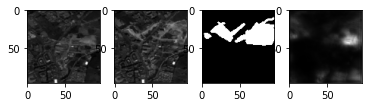

Dice similarity score is 0.09737791151975721


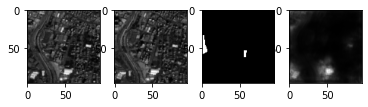

Dice similarity score is 0.0101458599707959


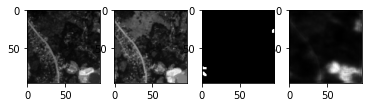

Dice similarity score is 0.013722477576445874


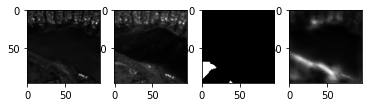

Dice similarity score is 0.03750224725665022


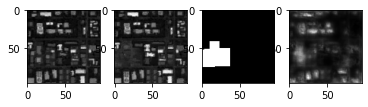

Dice similarity score is 0.07065213967335818


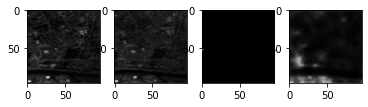

Dice similarity score is 0.001092863645073616


In [6]:
model = unet()
model.save_weights('model4.h5')
history = model.fit([X1_train,X2_train], y_train, batch_size=2, epochs=10, verbose=1,validation_split=0.2, shuffle=True)
results = model.predict([X1_test,X2_test])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)

print(model.summary)


plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


from scipy.spatial import distance

sumdice = 0
for i in range(10):

  img = results[i]
  img1 = y_test[i]
  img2 = X1_test[i]
  img3 = X2_test[i]
  fig, (ax1, ax2, ax3, ax4) =  plt.subplots(1,4)
  ax1.imshow(img2[:,:,0], cmap = 'gray')
  ax2.imshow(img3[:,:,1], cmap = 'gray')
  ax4.imshow(img[:,:,0], cmap = 'gray')
  ax3.imshow(img1[:,:,0], cmap = 'gray')
  plt.show()
  dice = np.sum(img[:,:,0][img1[:,:,0]==1])*2.0 / (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  print("Dice similarity score is {}".format(dice))

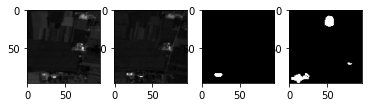

Dice similarity score is 0.13008130081300814


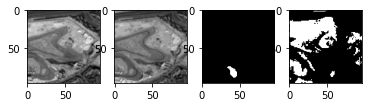

Dice similarity score is 0.0


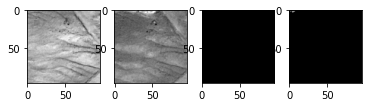

Dice similarity score is 0.0


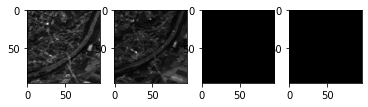

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


Dice similarity score is nan


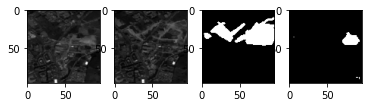

Dice similarity score is 0.27146529562982


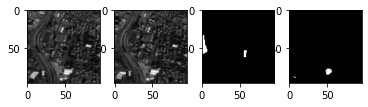

Dice similarity score is 0.0


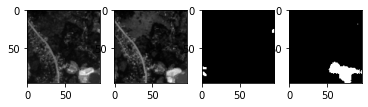

Dice similarity score is 0.0


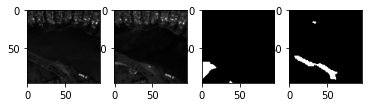

Dice similarity score is 0.0


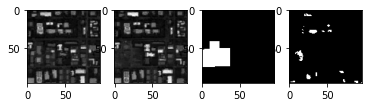

Dice similarity score is 0.10501193317422435


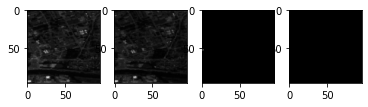

Dice similarity score is 0.0


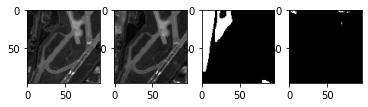

Dice similarity score is 0.03729903536977492


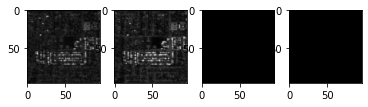

Dice similarity score is nan


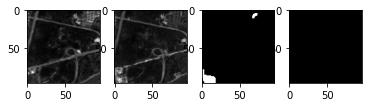

Dice similarity score is 0.0


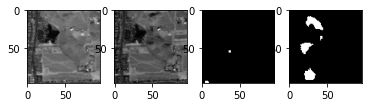

Dice similarity score is 0.0


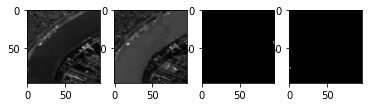

Dice similarity score is 0.0


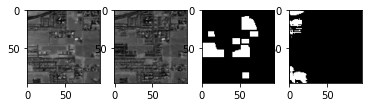

Dice similarity score is 0.008200922603792926


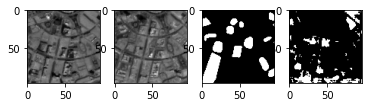

Dice similarity score is 0.14518229166666666


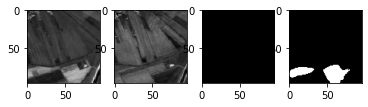

Dice similarity score is 0.0


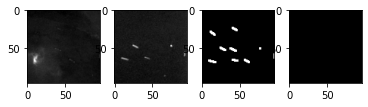

Dice similarity score is 0.0


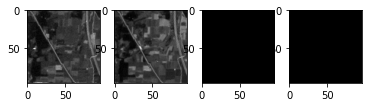

Dice similarity score is nan


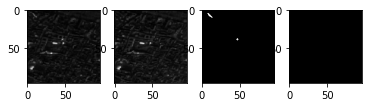

Dice similarity score is 0.0


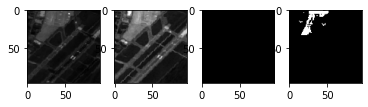

Dice similarity score is 0.0


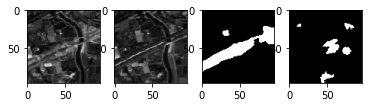

Dice similarity score is 0.22604422604422605


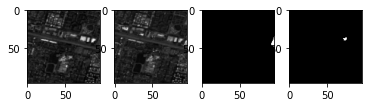

Dice similarity score is 0.0


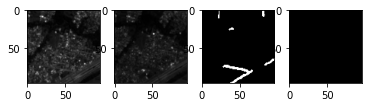

Dice similarity score is 0.0


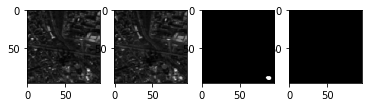

Dice similarity score is 0.0


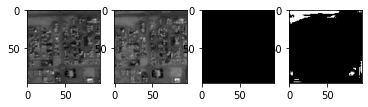

Dice similarity score is 0.0


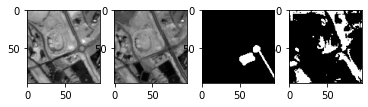

Dice similarity score is 0.12903225806451613


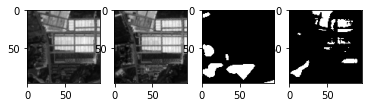

Dice similarity score is 0.16216216216216217


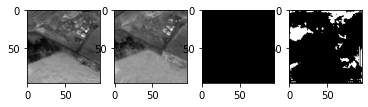

Dice similarity score is 0.0


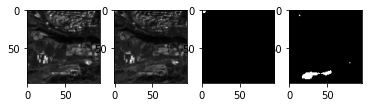

Dice similarity score is 0.0


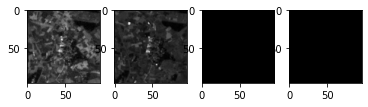

Dice similarity score is nan


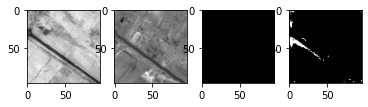

Dice similarity score is 0.0


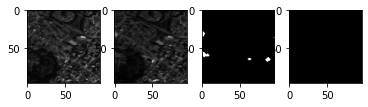

Dice similarity score is 0.0


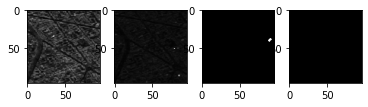

Dice similarity score is 0.0


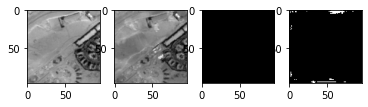

Dice similarity score is 0.0


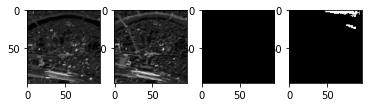

Dice similarity score is 0.0


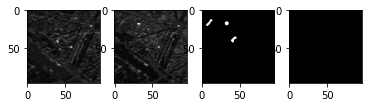

Dice similarity score is 0.0


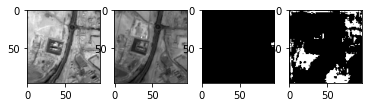

Dice similarity score is 0.0036719706242350062


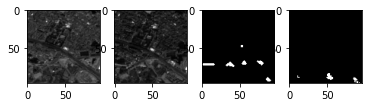

Dice similarity score is 0.12878787878787878


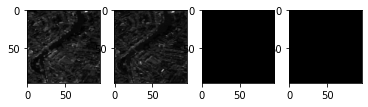

Dice similarity score is nan


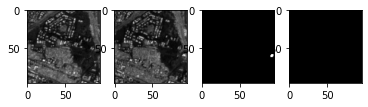

Dice similarity score is 0.0


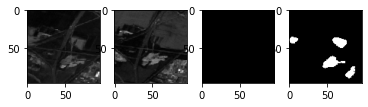

Dice similarity score is 0.0


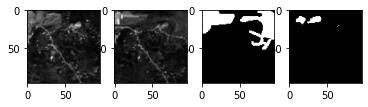

Dice similarity score is 0.19158200290275762


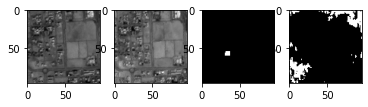

Dice similarity score is 0.0


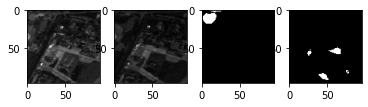

Dice similarity score is 0.0


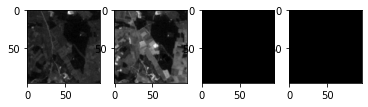

Dice similarity score is nan


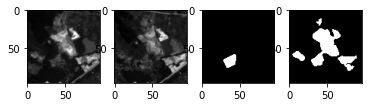

Dice similarity score is 0.21449970041941283


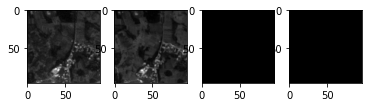

Dice similarity score is nan


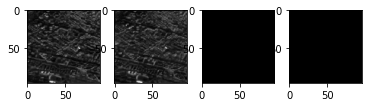

Dice similarity score is nan


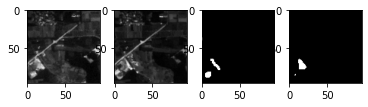

Dice similarity score is 0.4978165938864629


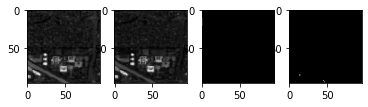

Dice similarity score is 0.0


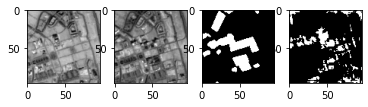

Dice similarity score is 0.3258096172718351


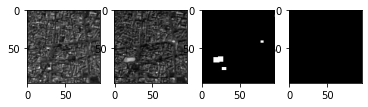

Dice similarity score is 0.0


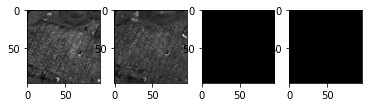

Dice similarity score is nan


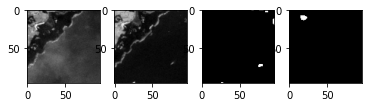

Dice similarity score is 0.0


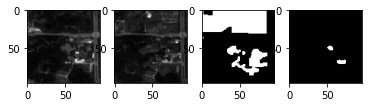

Dice similarity score is 0.035542168674698796


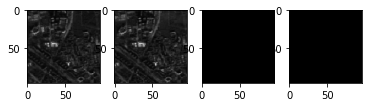

Dice similarity score is nan


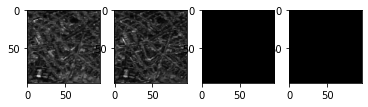

Dice similarity score is nan


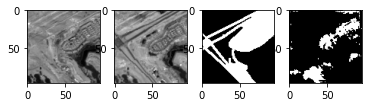

Dice similarity score is 0.3714063714063714


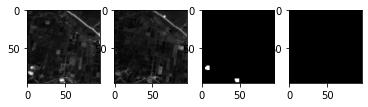

Dice similarity score is 0.0


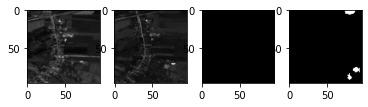

Dice similarity score is 0.0


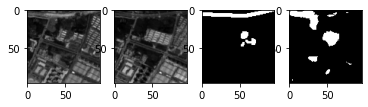

Dice similarity score is 0.4258064516129032


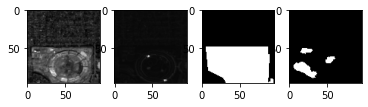

Dice similarity score is 0.23204419889502761


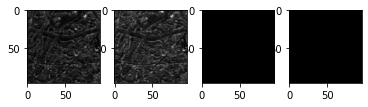

Dice similarity score is nan


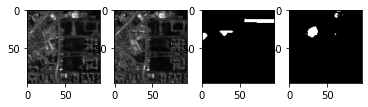

Dice similarity score is 0.2567287784679089


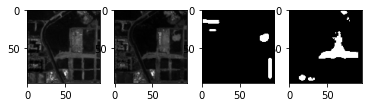

Dice similarity score is 0.0


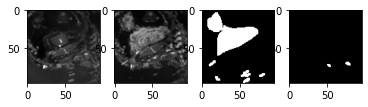

Dice similarity score is 0.0


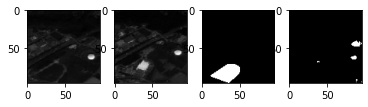

Dice similarity score is 0.0


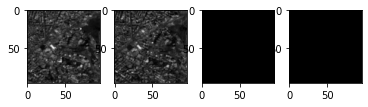

Dice similarity score is nan


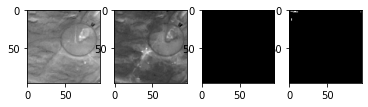

Dice similarity score is 0.0


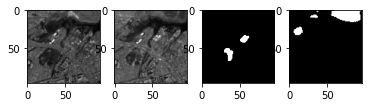

Dice similarity score is 0.0


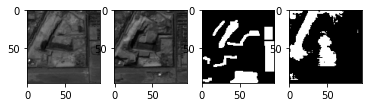

Dice similarity score is 0.09975550122249388


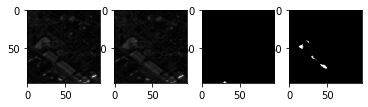

Dice similarity score is 0.0


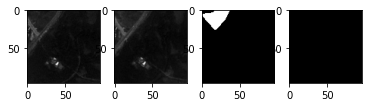

Dice similarity score is 0.0


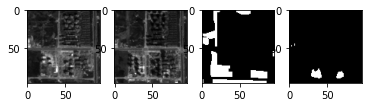

Dice similarity score is 0.16363636363636364


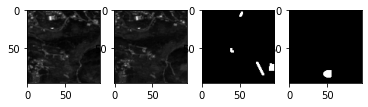

Dice similarity score is 0.0


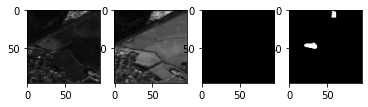

Dice similarity score is 0.0


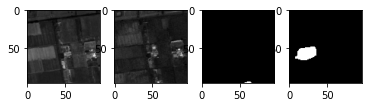

Dice similarity score is 0.0


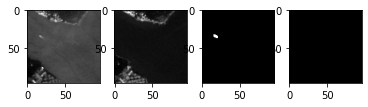

Dice similarity score is 0.0


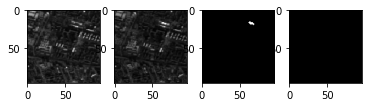

Dice similarity score is 0.0


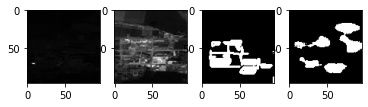

Dice similarity score is 0.4108040201005025


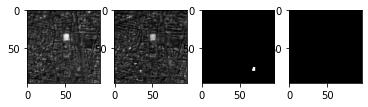

Dice similarity score is 0.0


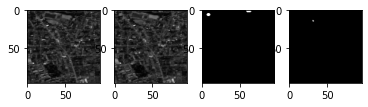

Dice similarity score is 0.0


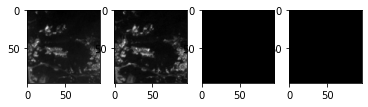

Dice similarity score is nan


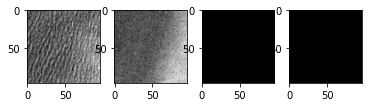

Dice similarity score is nan


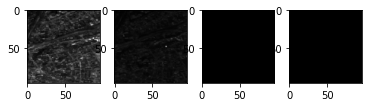

Dice similarity score is nan


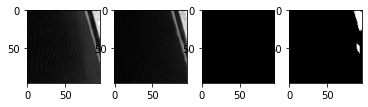

Dice similarity score is 0.0


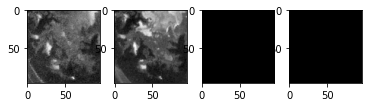

Dice similarity score is nan


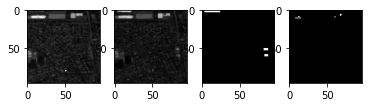

Dice similarity score is 0.0


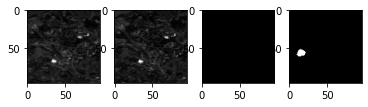

Dice similarity score is 0.0


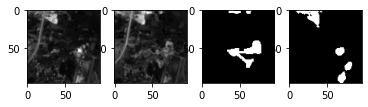

Dice similarity score is 0.17151848937844216


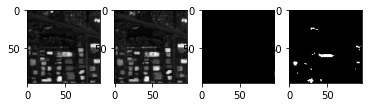

Dice similarity score is 0.0


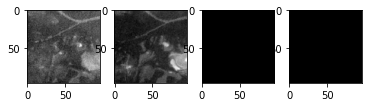

Dice similarity score is nan


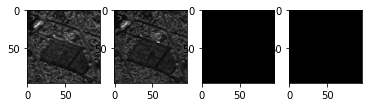

Dice similarity score is nan


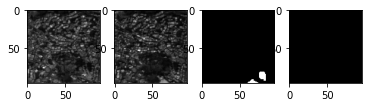

Dice similarity score is 0.0


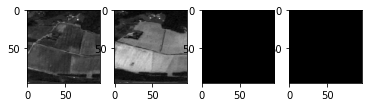

Dice similarity score is nan


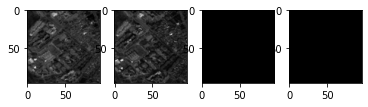

Dice similarity score is nan


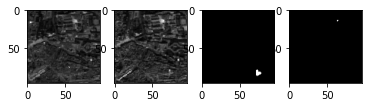

Dice similarity score is 0.0


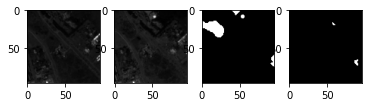

Dice similarity score is 0.003552397868561279
Dice similarity score is 0.14549221033514004


In [7]:
tempArray = np.copy(results)
for element in np.nditer(tempArray, op_flags=['readwrite']):
  if element > .1:
    element[...] = 1
  else:
    element[...] = 0
y = []
numer = 0
denom = 0
for i in range(100):
  img = tempArray[i]
  img1 = y_test[i]
  img2 = X1_test[i]
  img3 = X2_test[i]
  fig, (ax1, ax2, ax3, ax4) =  plt.subplots(1,4)
  ax1.imshow(img2[:,:,0], cmap = 'gray')
  ax2.imshow(img3[:,:,0], cmap = 'gray')
  ax4.imshow(img[:,:,0], cmap = 'gray')
  ax3.imshow(img1[:,:,0], cmap = 'gray')
  plt.show()
  dice = np.sum(img[:,:,0][img1[:,:,0]==1])*2.0 / (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  numer += np.sum(img[:,:,0][img1[:,:,0]==1])
  denom += (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  dice1 = np.sum(img[:,:,0][img1[:,:,0]==1])*2.0 / (np.sum(img[:,:,0]) + np.sum(img1[:,:,0]))
  print("Dice similarity score is {}".format(dice1))
  dice = numer * 2/ denom

print("Dice similarity score is {}".format(dice))